In [9]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import preprocessing

In [5]:
%pylab inline
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Populating the interactive namespace from numpy and matplotlib


In [15]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
train_stances = pd.read_csv("fn_data/train_stances.csv")

In [23]:
raw_corpus = u""
for body in list(train_bodies["articleBody"]):
    raw_corpus+=body
for headline in list(train_stances['Headline']):
    raw_corpus+= (headline+". ")
len(raw_corpus)

7271604

In [24]:
sentences = [preprocessing.get_clean_tokens(s) for s in nltk.tokenize.sent_tokenize(raw_corpus) if len(s)>0]

In [25]:
token_count = sum([len(s) for s in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 751,958 tokens


In [37]:
#more dimensions, more computationally expensive to train but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [33]:
news2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [34]:
news2vec.build_vocab(sentences)

2018-10-09 21:03:41,305 : INFO : collecting all words and their counts
2018-10-09 21:03:41,307 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-10-09 21:03:41,357 : INFO : PROGRESS: at sentence #10000, processed 132318 words, keeping 13476 word types
2018-10-09 21:03:41,403 : INFO : PROGRESS: at sentence #20000, processed 263639 words, keeping 18337 word types
2018-10-09 21:03:41,441 : INFO : PROGRESS: at sentence #30000, processed 375587 words, keeping 20787 word types
2018-10-09 21:03:41,468 : INFO : PROGRESS: at sentence #40000, processed 454446 words, keeping 20807 word types
2018-10-09 21:03:41,489 : INFO : PROGRESS: at sentence #50000, processed 532502 words, keeping 20811 word types
2018-10-09 21:03:41,515 : INFO : PROGRESS: at sentence #60000, processed 610897 words, keeping 20813 word types
2018-10-09 21:03:41,539 : INFO : PROGRESS: at sentence #70000, processed 689261 words, keeping 20813 word types
2018-10-09 21:03:41,564 : INFO : collected 208

In [36]:
print("Word2Vec vocabulary length:", len(news2vec.wv.vocab))

Word2Vec vocabulary length: 10542


In [39]:
# takes about 1 min
news2vec.train(sentences, total_examples = len(sentences), epochs = 10)

2018-10-09 21:06:40,097 : INFO : training model with 4 workers on 10542 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-10-09 21:06:41,195 : INFO : EPOCH 1 - PROGRESS: at 20.39% examples, 178047 words/s, in_qsize 7, out_qsize 0
2018-10-09 21:06:42,237 : INFO : EPOCH 1 - PROGRESS: at 63.64% examples, 229977 words/s, in_qsize 7, out_qsize 0
2018-10-09 21:06:42,762 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-09 21:06:42,828 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-09 21:06:42,859 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-10-09 21:06:42,875 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-10-09 21:06:42,878 : INFO : EPOCH - 1 : training on 751958 raw words (696991 effective words) took 2.8s, 251547 effective words/s
2018-10-09 21:06:43,957 : INFO : EPOCH 2 - PROGRESS: at 11.65% examples, 104231 words/s, in_qsize 7, out_qsize 0
2018-10-09 2

(6969766, 7519580)

In [40]:
news2vec.save("./news2vec.w2v")

2018-10-09 21:08:36,675 : INFO : saving Word2Vec object under ./news2vec.w2v, separately None
2018-10-09 21:08:36,677 : INFO : not storing attribute vectors_norm
2018-10-09 21:08:36,680 : INFO : not storing attribute cum_table
2018-10-09 21:08:37,077 : INFO : saved ./news2vec.w2v


In [41]:
news2vec = w2v.Word2Vec.load("./news2vec.w2v")

2018-10-09 21:08:39,467 : INFO : loading Word2Vec object from ./news2vec.w2v
2018-10-09 21:08:39,702 : INFO : loading wv recursively from ./news2vec.w2v.wv.* with mmap=None
2018-10-09 21:08:39,703 : INFO : setting ignored attribute vectors_norm to None
2018-10-09 21:08:39,704 : INFO : loading vocabulary recursively from ./news2vec.w2v.vocabulary.* with mmap=None
2018-10-09 21:08:39,705 : INFO : loading trainables recursively from ./news2vec.w2v.trainables.* with mmap=None
2018-10-09 21:08:39,707 : INFO : setting ignored attribute cum_table to None
2018-10-09 21:08:39,708 : INFO : loaded ./news2vec.w2v


In [45]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_wv_matrix = news2vec.wv.syn0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [47]:
#this takes like 5 mins
all_wv_matrix_2d = tsne.fit_transform(all_wv_matrix)

In [50]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_wv_matrix_2d[news2vec.wv.vocab[word].index])
            for word in news2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head()

,word,x,y
0,small,-55.867798,1.304695
1,meteorite,-61.373898,-21.995361
2,crashed,-57.390240,-23.713593
3,wooded,-59.235725,-23.544374
4,area,68.131584,-24.047316


In [51]:
sns.set_context("poster")

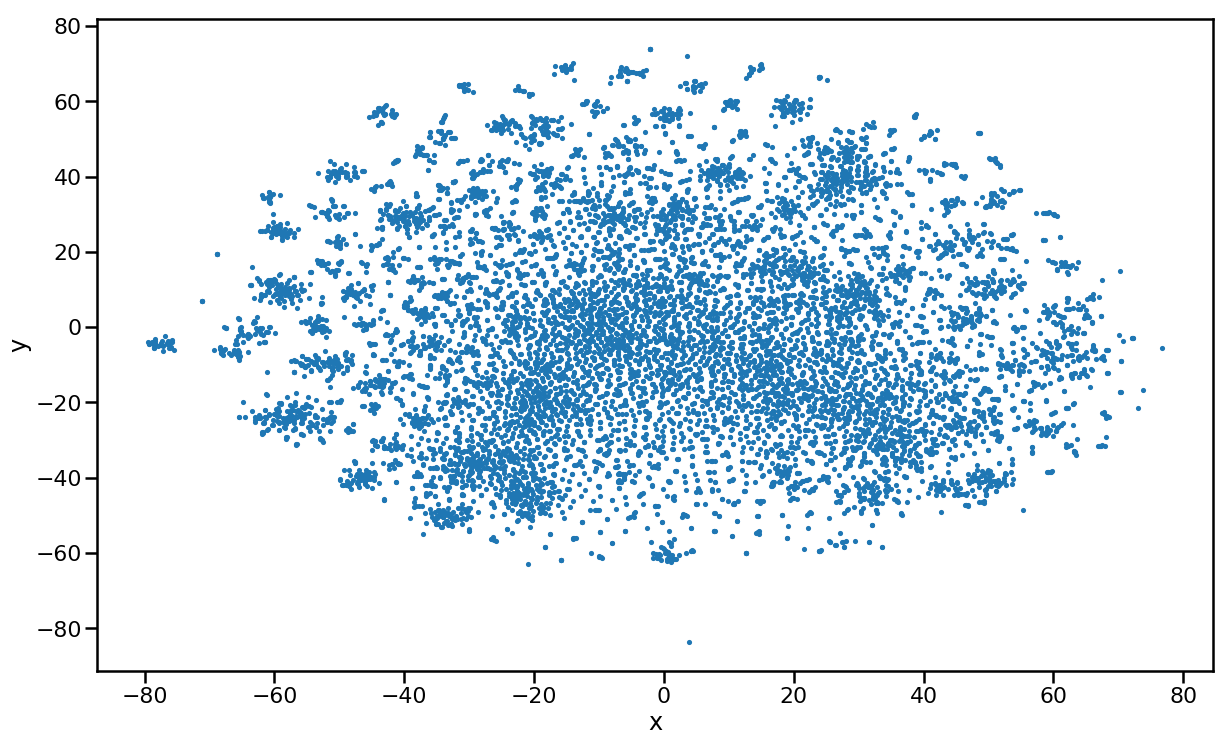

In [52]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [54]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


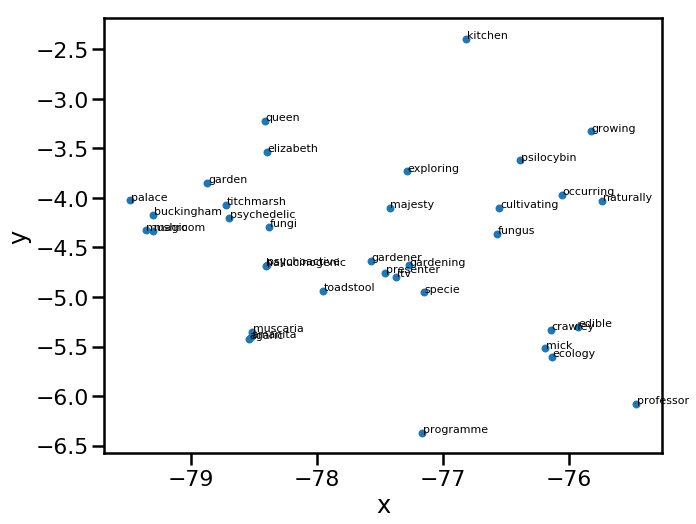

In [55]:
plot_region(x_bounds=(-80, -70), y_bounds=(-10, 0))

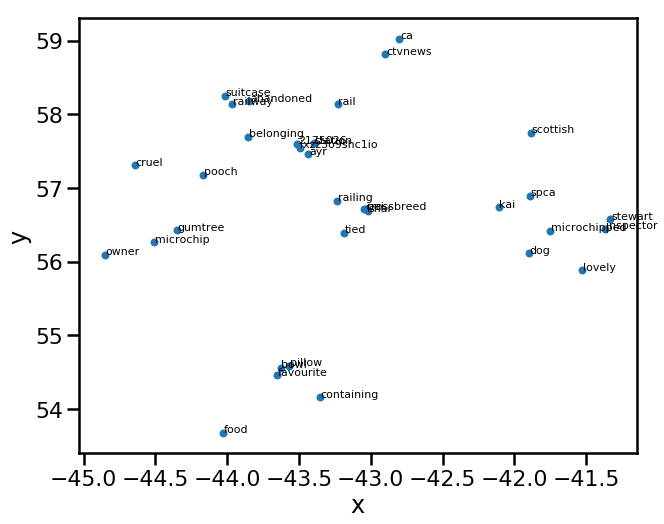

In [65]:
plot_region(x_bounds=(-45, -40), y_bounds=(50, 60))

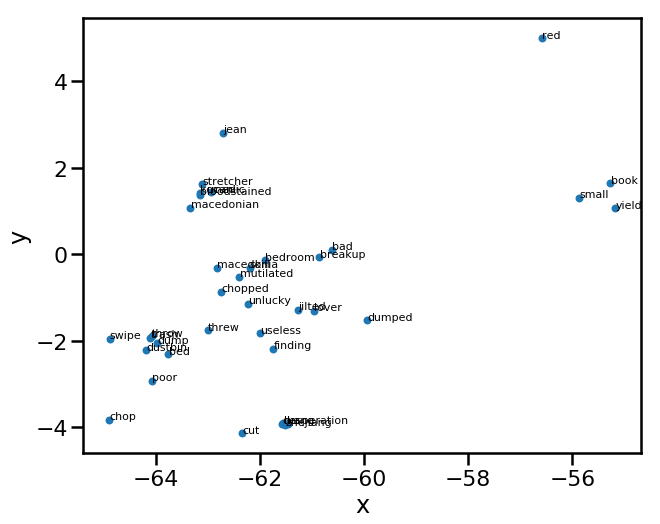

In [63]:
plot_region(x_bounds=(-65, -55), y_bounds=(-5, 5))

In [ ]:
plot_region(x_bounds=(-65, -55), y_bounds=(-5, 5))

In [70]:
news2vec.wv.most_similar("kurd")

[('dominant', 0.7527989745140076),
 ('embattled', 0.7150425910949707),
 ('idf', 0.7002279162406921),
 ('seize', 0.6880869269371033),
 ('battling', 0.6814746856689453),
 ('zionist', 0.6667063236236572),
 ('taunt', 0.6660432815551758),
 ('foe', 0.6644951701164246),
 ('airdropped', 0.6641950607299805),
 ('kidnaps', 0.6630229949951172)]

In [71]:
news2vec.wv.most_similar("fake")

[('pornographic', 0.563633918762207),
 ('msmbc', 0.5632755160331726),
 ('sensational', 0.5620168447494507),
 ('reckless', 0.5597500801086426),
 ('dailybuzzlive', 0.5527418851852417),
 ('crappy', 0.5514391660690308),
 ('hoaxer', 0.5501604080200195),
 ('distressing', 0.5483014583587646),
 ('onion', 0.5445740222930908),
 ('directory', 0.5423332452774048)]

In [72]:
news2vec.wv.most_similar("murder")

[('conscience', 0.6260561347007751),
 ('appalling', 0.6088033318519592),
 ('unpunished', 0.6053680181503296),
 ('nsc', 0.6010180711746216),
 ('depraved', 0.6004663705825806),
 ('barbaric', 0.600068211555481),
 ('heinous', 0.5969408750534058),
 ('hooded', 0.5843333601951599),
 ('appalled', 0.5765727162361145),
 ('2002', 0.5723026990890503)]

In [73]:
news2vec.wv.most_similar("chemical")

[('udpated', 0.7150118947029114),
 ('madness', 0.7052460312843323),
 ('mustard', 0.6968461275100708),
 ('convention', 0.6938680410385132),
 ('biological', 0.6927077770233154),
 ('choking', 0.6875168085098267),
 ('sarin', 0.6868339776992798),
 ('eliminate', 0.6855762600898743),
 ('degraded', 0.6838906407356262),
 ('weapon', 0.6724167466163635)]

In [74]:
news2vec.wv.most_similar("news")

[('fox', 0.5021642446517944),
 ('foxnews', 0.457086443901062),
 ('cn', 0.4427490830421448),
 ('msmbc', 0.4321953058242798),
 ('griffin', 0.4296194016933441),
 ('impersonator', 0.4282756447792053),
 ('cntv', 0.42034056782722473),
 ('foxnewsfacts', 0.41775137186050415),
 ('demise', 0.4154045581817627),
 ('affiliation', 0.41477468609809875)]

In [75]:
news2vec.wv.most_similar("spider")

[('burrowed', 0.8156851530075073),
 ('burrowing', 0.7778378129005432),
 ('scar', 0.7692763805389404),
 ('skin', 0.7594454884529114),
 ('tropical', 0.7564632892608643),
 ('crawl', 0.7531726360321045),
 ('maxwell', 0.7393032312393188),
 ('bali', 0.7390643358230591),
 ('navel', 0.7386879920959473),
 ('dylan', 0.7372491359710693)]

In [76]:
news2vec.wv.most_similar("navy")

[('ordnance', 0.6892075538635254),
 ('salem', 0.665987491607666),
 ('unmanned', 0.6479538679122925),
 ('zad', 0.6473860144615173),
 ('lt', 0.6426633596420288),
 ('armored', 0.6368802189826965),
 ('reconnaissance', 0.6335161924362183),
 ('manned', 0.6329810619354248),
 ('commanding', 0.6265143156051636),
 ('nasib', 0.6162036657333374)]

In [77]:
news2vec.wv.most_similar("soldier")

[('ontario', 0.5620042681694031),
 ('tomb', 0.5609809160232544),
 ('bredi', 0.5556919574737549),
 ('regiment', 0.5467674732208252),
 ('nathan', 0.544005274772644),
 ('shia', 0.543846845626831),
 ('cpr', 0.5435193181037903),
 ('cirillo', 0.5433973670005798),
 ('corporal', 0.5376552939414978),
 ('richelieu', 0.5360360741615295)]

In [79]:
news2vec.wv.most_similar("tomato")

[('ingested', 0.8548328876495361),
 ('allergen', 0.7926856279373169),
 ('genetically', 0.7260648012161255),
 ('anaphylaxis', 0.7253806591033936),
 ('seafood', 0.7253252863883972),
 ('allergic', 0.7219130992889404),
 ('marinated', 0.6974674463272095),
 ('bacon', 0.6845950484275818),
 ('antibiotic', 0.6769755482673645),
 ('uncooked', 0.6649512648582458)]

In [81]:
news2vec.wv.most_similar("burger")

[('1995', 0.7636902332305908),
 ('mould', 0.758065938949585),
 ('adelaide', 0.7463400363922119),
 ('casey', 0.7429927587509155),
 ('snack', 0.7425695657730103),
 ('pounder', 0.7419909238815308),
 ('dean', 0.7405339479446411),
 ('mate', 0.7365967631340027),
 ('dared', 0.7222699522972107),
 ('bloke', 0.7221399545669556)]

In [82]:
news2vec.wv.most_similar("rumor")

[('debunked', 0.5478326678276062),
 ('rebuff', 0.5125137567520142),
 ('ripfidel', 0.50749671459198),
 ('yusnaby', 0.4991798400878906),
 ('dissident', 0.4784122109413147),
 ('grain', 0.4697955250740051),
 ('fidel', 0.4685450792312622),
 ('wildest', 0.4664556086063385),
 ('pérez', 0.4651085138320923),
 ('rife', 0.46337515115737915)]

In [85]:
news2vec.wv.most_similar("denies")

[('agreeing', 0.5810461640357971),
 ('contradicting', 0.5769506692886353),
 ('provision', 0.5553627014160156),
 ('vein', 0.5550401210784912),
 ('furtherance', 0.5538403391838074),
 ('shehu', 0.5534041523933411),
 ('cogat', 0.553141713142395),
 ('declare', 0.5517212152481079),
 ('concession', 0.5485565066337585),
 ('memorized', 0.5477540493011475)]

In [86]:
news2vec.wv.most_similar("false")

[('categorically', 0.6839364767074585),
 ('ripfidel', 0.5950082540512085),
 ('dispel', 0.5873992443084717),
 ('fiction', 0.5802823305130005),
 ('proven', 0.5773980617523193),
 ('dhs', 0.5739457011222839),
 ('unequivocally', 0.5738277435302734),
 ('steinberg', 0.5626026391983032),
 ('timeline', 0.5552102327346802),
 ('catron', 0.5515815019607544)]

In [ ]:
news2vec.wv.most_similar("false")